# Numerically solving the 1D Ising model with nested sampling

This notebook shows how the thermodynamic behaviour of the 1D Ising model can be numerically determined with nested sampling.

The 1d Ising model is made up of a chain of "spins", which may point either up or down. In this case we consider N spins with periodic boundary conditions such that the 1st and Nth spins are neighbours, like we have closed the chain at each end to form a loop.

A configuration of these spins may for example look like this:

\begin{equation}
\dots \uparrow \uparrow \downarrow \uparrow \downarrow \downarrow \uparrow \downarrow \uparrow\uparrow \downarrow \downarrow\uparrow\uparrow \downarrow \dots
\end{equation}

We represent a configuration with the set of values $\{\sigma_i\}$, where $i$ is the index of each spin ($i = 1,\dots,N$) and $\sigma = \pm 1$

Spins interact with their neighbours through exchange coupling, in that each spin may raise or lower the total energy of the system depending on how it aligns with its neighbours.

The energy of a configuration is therefore given by the following Hamiltonian:

\begin{equation}
\mathcal{H} = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
\end{equation}

where $J$ is the exchange constant, informing the strength and form of the interactions.

If J > 0 spins save energy by aligning, leading to ferromagnetism.

If J < 0 spins save energy by anti-aligning, leading to anti-ferromagnetism.

$\langle i,j \rangle $ indicates that we are summing over nearest neighbour pairs.

The order parameter in which we're interested is the total normalised magnetisation, given by:

\begin{equation}
   m =  \frac{1}{N}\sum_i \sigma_i
\end{equation}

With nested sampling we aim to efficiently sample the different possible configurations and their energies, providing ensemble averages of the energy and total magnetisation at different temperatures.

In [308]:
""" Nested sampling (NS) of the 1D Ising model """

import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import trange

rng = np.random.default_rng(1)


def calculate_energy(configuration):
    """ Calculate the energy of a 1D configuration of spins """
    energy = 0
    for i in range(len(configuration)):
        energy -= configuration[i] * configuration[i - 1]
    energy += rng.uniform() / 1e6 # add small energy from uniform distribution to lift degeneracies
    return energy


def find_limit(energies):
    """ Find the index of the maximum-energy walker """
    energy_limit = np.max(energies)
    index_limit = np.argwhere(energies == energy_limit).flatten()
    return energy_limit, index_limit

def spin_flips(number_of_steps, number_of_spins, energy_limit, walkers, energies, i_limit, verbose=False):
    """ Generation of new walker through cloning and random walk process """
    
    # save data of initial walker 
    energy_initial = energies[i_limit]
    walker_initial = walkers[i_limit]
    
    # verbosity for bug fixing!
    if verbose:
        print(f"INITIAL Walker {i_limit} {walker_initial} Energy {energy_initial} limit {energy_limit}")
    
    # choose a walker at random to clone
    rand_ind = rng.integers(low=0, high=len(walkers), size=1)[0]
    walker = walkers[rand_ind].copy()
    
    # initial energy of clone
    energy_prev = energies[rand_ind].copy()
    
    if verbose:
        energy_check = calculate_energy(walker)
        if abs(energy_prev - energy_check) > 0.5:
            print(f"WARNING MISMATCH INIT ENERGY (SAVED: {rand_ind} {energy_prev} RECALC: {energy_check} {walker})")
        #print("CLONE:", rand_ind, energy_prev, walker)
        print(f"CLONE {rand_ind} {walker} Energy {energy_prev}")
    
    n_accept = 0
    #print(f"CLONED WALKER: {walker} Energy {energy_prev}")
    for i in range(number_of_steps):

        # choose a spin at random
        spin = rng.integers(low=0, high=number_of_spins, size=1)[0]
        
        # flip spin
        #print(f"Step {i} BEFORE Walker {walker}")
        #energy_initial = energy_prev
        if verbose:
            print(f"Step {i} BEFORE Walker {walker} Energy {energy_prev}")
        
        # flip spin
        walker[spin] *= -1
        
        # check energy after flip
        energy = calculate_energy(walker)
        
        if verbose:
            print(f"Step {i} FLIP {spin} Walker {walker} Energy {energy}")
        
        # Does energy exceed the limit set by the initial max energy walker?
        # If yes, reject!
        if energy >= energy_limit:
            if verbose:
                print(f"Step {i} REJECT Walker {walker} energy {energy}  limit {energy_limit}")
            walker[spin] *= -1
            energy = energy_prev
            if verbose:
                print(f"Step {i} RESTORE Walker {walker} energy {energy}  limit {energy_limit}")
            accept = False
        # If no, accept!
        else:
            n_accept += 1
            accept = True
            energy_prev = energy
            if verbose:
                print(f"Step {i} ACCEPT Walker {walker} energy {energy} limit {energy_limit}")
    
    if verbose:
        energy_check = calculate_energy(walker)
        if abs(energy - energy_check) > 0.5:
            print(f"WARNING MISMATCH AFTER ENERGY (SAVED: {energy} RECALC: {energy_check} {walker})")
        
    return walker, energy, n_accept/number_of_steps

def run_ns(N_spin = 50, N_walker = 200, N_iteration = 50000, N_step = 100, N_record = 100):
    """ """
    # Parameters for NS of the 1D Ising model
    # N_spin = number of spins in 1D Ising model
    # N_walker = number of walkers in NS
    # N_iteration = number of iterations in NS
    # N_step = number of steps per walk
    # N_record = frequency at which configurations are saved
    
    # Generate `N_walker` walkers (W) each with `N_spin` spins
    W = rng.integers(low=0, high=2, size=(N_walker, N_spin)) * 2 - 1
    E_W = np.apply_along_axis(calculate_energy, 1, W)  # energies (E) of walkers

    # Start NS
    E_limit = np.zeros(N_iteration)
    mag_limit = np.zeros(N_iteration)
    saved_configs = []
    
    for i in trange(N_iteration):
        # Find maximum-energy walker and store its energy and magnetisation
        E_limit_i, i_limit = find_limit(E_W)
        E_limit[i] = E_limit_i
        mag_limit[i] = np.sum(W[i_limit[0]])
        
        # Store configuration after N_record iterations
        if i%N_record == 0:
            config_info = {
                "configuration": W[i_limit[0]].copy(),
                "iteration": i+1,
                "energy": E_limit_i,
                "magnetisation": mag_limit[i],
                "temperature": None
            }
            saved_configs += [config_info]

        # Generate walker to replace maximum-energy walker
        if False: #i%1000 == 0:
            verbose = True
        else:
            verbose = False
                
        W_i, E_W_i, acc_ratio = spin_flips(N_step, N_spin, E_limit_i, W, E_W, i_limit[0], verbose=verbose)

        # Replace maximum energy walker with cloned and decorrelated walker
        W[i_limit[0]] = W_i.copy()
        E_W[i_limit[0]] = E_W_i.copy()
    
    return E_limit, mag_limit, saved_configs

def analyse_NS(energies, magnetisations, N_walker, N_spin, kTdiv=0.05, kTmax=4):
    """ Calculate ensemble averages of energy, magnetisation and absolute magnetisation over range of temperatures """ 
    
    chi_0 = 1E7 #arbitrary scaling factor
    
    #list of iteration numbers
    iters = np.arange(len(energies)) + 1
    
    # Phase space volume below configuration of iteration i-1
    zetas_old = (N_walker / (N_walker + 1)) ** (iters - 1)
    # Phase space volume below configuration of iteration i
    zetas_new = (N_walker / (N_walker + 1)) ** iters
    delta_chi = chi_0 * (zetas_old - zetas_new)
    
    #list of temperatures at which average quantities are calculated
    kTs = np.linspace(kTdiv, kTmax, int(kTmax / kTdiv))
    
    #empty lists of average energies, magnetisations
    enavg_energ = np.zeros(len(kTs))
    enavg_mag = np.zeros(len(kTs))
    enavg_absmag = np.zeros(len(kTs))
    
    #reference energy
    E0 = min(energies)
    
    #sum for calculation of ensemble averages
    for i, kT in enumerate(kTs):
        eng_numer = np.sum(delta_chi * np.exp(-(energies-E0) / kT) * energies)
        mag_numer = np.sum(delta_chi * np.exp(-(energies-E0) / kT) * magnetisations)
        absmag_numer = np.sum(delta_chi * np.exp(-(energies-E0) / kT) * np.absolute(magnetisations))
        denom = np.sum(delta_chi * np.exp(-(energies-E0) / kT))
        enavg_energ[i] = eng_numer / denom / N_spin
        enavg_mag[i] = mag_numer / denom / N_spin
        enavg_absmag[i] = absmag_numer / denom / N_spin
        
    return kTs, enavg_energ, enavg_mag, enavg_absmag

def multi_run(N_run = 3, N_spin = 50, N_walker = 200, N_iteration = 50000, N_step = 100, N_record = 100):
    """ Perform multiple runs of NS with the same hyperparameters, to assess convergence."""
    energies_list = []
    mags_list = []
    configs_list = []
    for i in range(N_run):
        print(f"Performing NS run {i+1}...")
        energies, magnetisations, configurations = run_ns(N_spin=N_spin, N_walker=N_walker, 
                                                          N_iteration=N_iteration, N_step=N_step)
        
        energies_list += [energies]
        mags_list += [magnetisations]
        configs_list += [configurations]
        
    return energies_list, mags_list, configs_list
                
def multi_analyse(energies_list, mags_list, N_walker, N_spin, kTdiv=0.05, kTmax=4):
    """ Calculate ensemble averages for multiple NS runs and plot the results. """
    enavg_eng_list = []
    enavg_mag_list = []
    enavg_absmag_list = []
    
    plt.xlabel("$k_B T / J$")
    
    for i in range(len(energies_list)):
        kTs, enavg_energ, enavg_mag, enavg_absmag = analyse_NS(energies_list[i], mags_list[i], 
                                                               N_walker=N_walker, N_spin=N_spin,
                                                               kTdiv=kTdiv, kTmax=kTmax)
                
        enavg_eng_list += [enavg_energ]
        enavg_mag_list += [enavg_mag]
        enavg_absmag_list += [enavg_absmag]
        plt.figure(0)
        plt.plot(kTs, enavg_energ, "--", label=f"NS run {i+1}")
        plt.figure(1)
        plt.plot(kTs, enavg_absmag, "--", label=f"NS run {i+1}")
        plt.figure(2)
        plt.plot(kTs, enavg_mag, "--", label=f"NS run {i+1}")
    
    plt.figure(0)
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    exact_E = -np.tanh(1 / kTs)
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"Free energy")
    plt.plot(kTs, exact_E, "black", label="Exact")
    plt.legend()
    plt.plot()
    
    plt.figure(1)
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"Absolute magnetisation $\langle m \rangle$")
    #plt.plot(kTs, exact_E, "black", label="Exact")
    plt.legend()
    
    plt.figure(2)
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"Magnetisation $\langle | m | \rangle$")
    #plt.plot(kTs, exact_mag, "black", label="Exact")
    plt.legend()

def plot_ensemble_average_energy(kTs, enavg_energ, N_walker, N_spin, N_iteration, N_step):
    """ Plot ensemble averages of energy (free energy) for results of single run. """
    
    plt.plot(kTs, enavg_energ, "C0--", label="Nested sampling")
    # Exact result for free energy
    exact_E = -np.tanh(1 / kTs)
    plt.plot(kTs, exact_E, "C0", label="Exact")
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"$\langle E \rangle / N J$")
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    plt.legend()
    
def plot_ensemble_average_mag(kTs, enavg_mag, N_walker, N_spin, N_iteration, N_step):
    """ Plot ensemble averages of magnetisation for results of single run. """
    
    plt.plot(kTs, enavg_mag, "C0--", label="Nested sampling")
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"$\langle E \rangle / N J$")
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    plt.legend()
    
def plot_ensemble_average_absmag(kTs, enavg_absmag, N_walker, N_spin, N_iteration, N_step):
    """ PLot ensemble averages of absolute magnetisation for results of single run. """
    
    plt.plot(kTs, enavg_absmag, "C0--", label="Nested sampling")
    plt.xlabel("$k_B T / J$")
    plt.ylabel(r"$\langle E \rangle / N J$")
    plt.title(f"1D Ising Model with {N_spin} Spins, using {N_walker} walkers, {N_iteration} iterations, {N_step} steps per iter.")
    plt.legend()

The following commands will run NS using a given set of hyperparameters

In [310]:
# Parameters for NS of the 1D Ising model
N_spin = 5  # number of spins in 1D Ising model
N_walker = 20  # number of walkers in NS
N_iteration = 65 # number of iterations in NS
N_step = 20 # number of steps per walk

N_run = 3 # number of independent NS runs

energies_list, mags_list, configs_list = multi_run(N_run=N_run, N_spin=N_spin, N_walker=N_walker, 
                                                   N_iteration=N_iteration, N_step=N_step)

Performing NS run 1...


100%|██████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2134.32it/s]


Performing NS run 2...


100%|██████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1863.87it/s]


Performing NS run 3...


100%|██████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2004.65it/s]


With the following command we can analyse the output of NS and plot ensemble averages as a function of temperature.

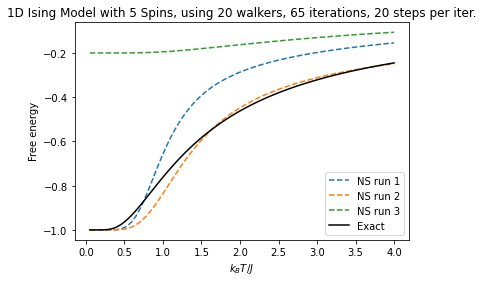

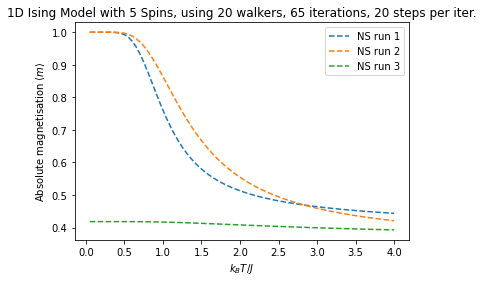

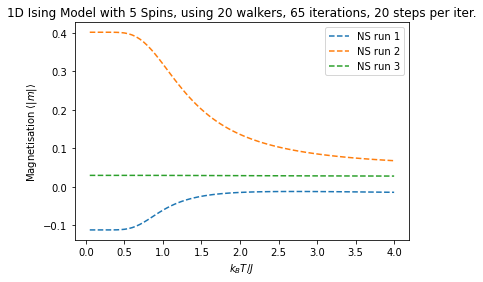

In [307]:
# These parameters set the range of temperatures over which ensemble averages will be calculated
kTdiv = 0.05 # temperature difference
kTmax = 4 # maximum temperature

multi_analyse(energies_list, mags_list, N_walker=N_walker, N_spin=N_spin, kTdiv=kTdiv, kTmax=kTmax)